In [43]:
import requests
import pandas as pd
import bs4
import PIL.Image as im
import collections
import os
from multiprocessing import Pool
import tqdm

In [5]:
#Loading flickr key
with open("private/flickr-id.txt") as f:
    key = f.readlines()[0][:-1]

In [9]:
#testing the connection:
res = requests.get(f"https://www.flickr.com/services/rest/?method=flickr.photos.search&api_key={key}&tags=polytechnique&per_page=50&page=1&extras=url_o,o_dims,original_format,tags")
assert res.status_code == 200

## Downloading

In [17]:
def get_page(tag, page, nb_photos = 500):
    res = requests.get(f"https://www.flickr.com/services/rest/?method=flickr.photos.search&api_key={key}&tags={tag}&per_page={nb_photos}&page={page}&extras=url_o,o_dims,original_format,tags")
    soup = bs4.BeautifulSoup(res.text)
    gen_infos = soup.find("photos")
    total_page = gen_infos["pages"]
    print(f"page {page} over {total_page}")
    
    photos_info = soup.find_all("photo")
    d = collections.defaultdict(list)
    for image_info in photos_info:
        d["id"].append(image_info["id"])
        d["server"].append(image_info["server"])
        d["secret"].append(image_info["secret"])
        d["height_o"].append(image_info["height_o"] if "height_o" in image_info.attrs else None)
        d["width_o"].append(image_info["width_o"] if "width_o" in image_info.attrs else None)
        d["tags"].append(image_info["tags"])
        d["title"].append(image_info["title"])
        d["url_o"].append(image_info["url_o"] if "url_o" in image_info.attrs else None)
        d["owner"].append(image_info["owner"])
    return pd.DataFrame(d)

def download_image_1024(im_row, im_path):
    server_id  = im_row["server"]
    im_id  = im_row["id"]
    secret  = im_row["secret"]
    size_suffix  = "b"
    im_res = requests.get(f"https://live.staticflickr.com/{server_id}/{im_id}_{secret}_{size_suffix}.jpg")
    if im_res.status_code == 200:
        with open(im_path , "wb") as f:
            f.write(im_res.content)
            #print("Done", im_id)
    else:
        print("error downloading", im_id)

def download(im_row, download_path="data/dogs-1024"):
        im_id  = im_row["id"]
        im_path = os.path.join(download_path, f"{im_id}.jpg")
        if not os.path.isfile(im_path):
            download_image_1024(im_row, im_path)
        
def download_dataset(dataset, process=8):
    with Pool(process) as p:
        p.map(download, [ir[1] for ir in dataset.iterrows()])

In [14]:
tag = "dog"
res = []
for i in range(0, 2):
    res.append(get_page(tag, i))
dataset = pd.concat(res)

page 0 over 264
page 1 over 248


In [19]:
download_dataset(dataset)

Done 50567037237
Done 50569195866
Done 50563687347
Done 50565198718
DoneDone  5056765656650563230533

Done 50564917168
Done 50568380928
Done 50566988347
Done 50565942886
DoneDone  5056391008150569261837

Done 50565750622
Done 50566745251
Done 50569094971
Done 50564857898
Done 50569048636
Done 50569181042
Done 50565419242
Done 50568298603
Done 50565255271
Done 50567626116
Done 50569180122
Done 50563409746
Done Done 50567760922
50565029011
Done 50569158052
Done 50566708701
Done 50565193458
Done 50563906626
Done 50567554956
Done 50566832433
Done 50566659512
Done 50567582996
Done 50563160888
Done 50566671987
Done 50563071598
Done 50533894226
Done 50565777483
Done 50568275488
DoneDone  5056384231250568819193

Done 50562745643
Done 50563773046
Done 50565164212
Done 50566754548
Done 50565192528
Done 50567498401
Done 50567498166
DoneDone  5056902519150568779143

Done 50568985601
Done 50562912693
Done 50565163012
Done 50565161667
Done 50569620912
Done 50567620412
Done 50568218443
Done 505687138

## Head extractor

In [44]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import utils

%matplotlib inline

In [15]:
tf.keras.backend.clear_session()
num_classes = 1
pipeline_config = '../models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/detection/checkpoints/dog-finetuned-checkpoint-2'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)
checkpoint = tf.train.Checkpoint(model=detection_model)
checkpoint.restore(checkpoint_path)
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

dog_class_id = 1
num_classes = 1
label_id_offset = 1
category_index = {dog_class_id: {'id': dog_class_id, 'name': 'rubber_ducky'}}

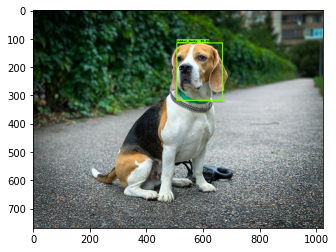

In [42]:
test_image_path = "data/dogs-1024/50562567067.jpg"
test_image_np = np.expand_dims(utils.load_image_into_numpy_array(test_image_path), axis=0)

@tf.function
def detect(input_tensor):
      """Run detection on an input image.

      Args:
        input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
          Note that height and width can be anything since the image will be
          immediately resized according to the needs of the model within this
          function.

      Returns:
        A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
          and `detection_scores`).
      """
      preprocessed_image, shapes = detection_model.preprocess(input_tensor)
      prediction_dict = detection_model.predict(preprocessed_image, shapes)
      return detection_model.postprocess(prediction_dict, shapes)

input_tensor = tf.convert_to_tensor(test_image_np, dtype=tf.float32) 
detections = detect(input_tensor)

utils.plot_detections(
    test_image_np[0],
    detections['detection_boxes'][0].numpy(),
    detections['detection_classes'][0].numpy().astype(np.uint32)
    + label_id_offset,
    detections['detection_scores'][0].numpy(),
    category_index, figsize=(15, 20))
